<a href="https://colab.research.google.com/github/saurabhmathur96/Speech-to-Text-Engine/blob/master/timit_speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install soundfile

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import zipfile

zipfile.ZipFile('My Drive/darpa-timit-acousticphonetic-continuous-speech.zip').extractall('..')

In [0]:
from pathlib import Path
import soundfile as sf 
from tqdm.auto import tqdm

def read_speech(base):
  signals = []
  targets = []
  base = Path(base)
  for accent in tqdm(base.iterdir()):
    for speaker in accent.iterdir():
      for f in speaker.iterdir():
        if f.suffix == '.wav':
          signal, rate = sf.read(f)
          signals.append(signal)

          target_file = f.name.replace('.WAV.wav', '.TXT')
          target_path = speaker / target_file
          words = open(target_path).read().strip().split(' ')[2:]
          target = ' '.join(words).lower().replace('.', '').replace(',', '').replace(' -- ', ' ').replace('-', ' ').replace('?', '').replace('"', '').replace('!', '').replace(':', '').replace(';', '')
          targets.append(target)
  return signals, targets


In [3]:
import torch
import torch.nn as nn
import librosa
import numpy as np
from tqdm.auto import trange, tqdm


class SpeechData(torch.utils.data.Dataset):
  def __init__(self, inputs, input_lengths, outputs, output_lengths):
    self.inputs = inputs
    self.input_lengths = torch.Tensor(input_lengths)
    self.outputs = outputs
    self.output_lengths = torch.Tensor(output_lengths)
    
    self.n = len(inputs)
  
  def __len__(self):
    return self.n
  
  def __getitem__(self, i):
    inp = self.inputs[i]
    inp_len = self.input_lengths[i]
    op = self.outputs[i]
    op_len = self.output_lengths[i]
    return inp, inp_len, op, op_len

#
# Training data
#
s, t = read_speech('../data/TRAIN')
chars = set(''.join(t))
char2index = { c: i+2 for i, c in enumerate(chars) }
char2index['<'] = 0
char2index['>'] = 1
print (char2index)

inputs = []
input_lengths =[]
outputs = []
output_lengths = []
for x, y in tqdm(zip(s, t), total=len(s)):
  inp = torch.from_numpy(np.abs(librosa.stft(x, n_fft=1024, hop_length=512)).T)
  inputs.append(inp)
  input_lengths.append(len(inp))

  output = torch.Tensor([char2index[c] for c in '<' + y + '>'])
  outputs.append(output)
  output_lengths.append(len(output)) 

train_data = SpeechData(inputs, input_lengths, outputs, output_lengths)


#
# Test data
#
s, t = read_speech('../data/TEST')
inputs = []
input_lengths =[]
outputs = []
output_lengths = []
for x, y in tqdm(zip(s, t), total=len(s)):
  inp = torch.from_numpy(np.abs(librosa.stft(x, n_fft=1024, hop_length=512)).T)
  inputs.append(inp)
  input_lengths.append(len(inp))

  output = torch.Tensor([char2index[c] for c in '<' + y + '>'])
  outputs.append(output)
  output_lengths.append(len(output)) 
test_data = SpeechData(inputs, input_lengths, outputs, output_lengths)


{'a': 2, 'b': 3, 'm': 4, ' ': 5, 'e': 6, 'q': 7, 'p': 8, 'h': 9, 't': 10, 'l': 11, 'o': 12, 'g': 13, 'x': 14, 'w': 15, 'k': 16, 'z': 17, 'r': 18, 'd': 19, 'u': 20, 'i': 21, 'n': 22, 'v': 23, 's': 24, 'y': 25, 'c': 26, 'j': 27, 'f': 28, "'": 29, '<': 0, '>': 1}


In [0]:
class SpeechNet(nn.Module):
  def __init__(self, device, input_size=513, output_size=len(char2index)+1, num_layers=3, hidden_size=1024):
    self.device = device
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    super(SpeechNet, self).__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    h = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    c = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    output, (h, c) = self.lstm(x, (h,c))
    # print (h.shape, c.shape)
    out = self.linear(output)
    return torch.nn.functional.log_softmax(out, 2)
  

def collate(batch):
  inp, inp_len, op, op_len = zip(*batch)
  inp = torch.nn.utils.rnn.pad_sequence(inp, batch_first=True, padding_value=len(char2index))
  inp_len = torch.stack(inp_len)
  op = torch.cat(op) # torch.nn.utils.rnn.pad_sequence(op, batch_first=True, padding_value=len(char2index))
  op_len = torch.stack(op_len)
  return inp, inp_len, op, op_len 


import torch.nn.init as init

def weight_init(m):
  if isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, collate_fn=collate)

In [34]:
from torch.autograd import Variable
from tqdm.auto import tqdm
import itertools


device = torch.device('cuda')

net = SpeechNet(device).to(device)
net.apply(weight_init)
clip_value = 1.0
# for p in net.parameters():
#   p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

clip_value = 1.0
criterion = nn.CTCLoss(blank=len(char2index), zero_infinity=True, reduction='none').to(device) #blank=0, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
losses = []
test_loss = []
for epoch in range(20):
  for inp, inp_len, op, op_len in tqdm(train_loader):
    
    inp, inp_len = Variable(inp.float()).to(device), Variable(inp_len.long()).to(device)
    op, op_len = Variable(op.long()).to(device), Variable(op_len.long()).to(device)

    optimizer.zero_grad()
    
    p = net(inp)
    
    loss = criterion(p.transpose(0,1), op, inp_len, op_len)
    # loss[loss == float("Inf")] = 0
    # print (loss.mean())
    
    loss = loss.mean()
    losses.append(loss.item())

    # torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)
    loss.backward()
    optimizer.step()
  print ('train loss = ', np.mean(losses[::-1][:len(train_loader)]))
  
  
  with torch.no_grad():
    for inp, inp_len, op, op_len in tqdm(test_loader):
        
        inp, inp_len = Variable(inp.float()).to(device), Variable(inp_len.long()).to(device)
        op, op_len = Variable(op.long()).to(device), Variable(op_len.long()).to(device)
        p = net(inp)
        
        loss = criterion(p.transpose(0,1), op, inp_len, op_len)
        
        loss = loss.mean()
        test_loss.append(loss.item())
    print ('test loss = ', np.mean(test_loss[::-1][:len(test_loader)]))

    index2char = dict(zip(char2index.values(), char2index.keys()))
    for pi in p:
      for i in (k for k, g in itertools.groupby(pi.argmax(1).cpu().numpy())):
        if i < len(index2char):
          print (index2char[i], end = '')
      print ()


train loss =  152.0222713075835



test loss =  140.0554603720611
<th
<th
<th
<th
<th
<th
<th
<th
<th
<th
<th
<th
<th
<th
<th
<th



train loss =  137.95302181901602



test loss =  135.622907242685
<he >
<he >
<he >
<he 
<he >
<he >
<he >
<he >
<he 
<he >
<he 
<he >
<he 
<he >
<he >
<he >



train loss =  121.10927187163254



test loss =  102.79439127220297
<she os re n e dote a thso>
<she a ote teifa a re tein foe tore fae>
<she sadin co eferssa ger a>
<she s on ter wa ie en genen>
<she hadeur dar sui in easyn was waer al yer>
<she as metocar e oaer a lik tha>
<she e din forn o hen>
<she toe me in ge he ea ateon>
<she char dan or cda torin iese on>
<she focoer meana de ton oa ie o tar>
<shes he sa robre> es sase war mreis on>
<sher an oder o porn rer de por en e e cafor>
<she pors sason e po e eas ten in en ce is wa eas to e es ta>
<shee wor ne er te in caan e e esspe pa> o as> in grers a e>
<shes pa ca  tois sa a  e ratha a sa> o assa  a la>
<she hda yor dark sui en reasy wa wae a yer>



train loss =  89.35741703428072



test loss =  81.07782241533387
<the eni sepl e caoler n ta sin ens>
<the had yok dark suit ian greasy wash watea all year>
<the ho ra de tot a io e a ti fos sol lal>
<theti e doen met was phi sting jso i>
<the sopo tat i ar creis of ardnandes pref he sist she i>
<the leos thin wo>
<the a oe th caso sooen h crast on hon wo la he>
<the cisior to geri san na reitat gas son ra seers ann o>
<the ol oariy o we soy oios>
<then ta o o ne a os a ain e>
<theer fro for file hooi noyn ths gae>
<the nose polon grs wa hoyin e sta>
<theffer at wite ga tet tisitrs i clats>
<the boo corpis o hol ca s>
<the oe osi so der grs sn e o swa e fo erth>
<the ra is so wa> at h atint in nf chani>



train loss =  74.91260644320784



test loss =  72.89168649349573
<te had your dark suit in greasy wash water all year>
<te we an e trin erelono i muth fucbly is pocsble>
<te tispe gans on yet fraue oun th sorth sothe smlalay>
<tes sur she sedie is et deuffin at>
<te warkcoro ton sissof on miy spurs on blass>
<tewomn an sember racanoing bee folns e>
<ten toerng o o bory ee porsort conta tes osns>
<tergistior orpars forrineor pro wo fornderae riy>
<tet ask me to carry an oily rag like that>
<te wethn mos sto contles supardas su tn othelarty>
<testeporar bagre catres swater>
<te wasan paetl d a pom en mus ficchowas an bosnstratit fee er>
<te e mes cry lasons onteris es>
<tebondol a was puantly iu ranting min shor>
<te curpons sto mar ever rangs formetin at>
<te was mo olver torola eu in tastions>



train loss =  65.70272553542564



test loss =  69.08358239227871
<e smon bo col te worn mondie ho c>
<e crin ber bob dit teriy therti an ow on>
<e hsidinspraingterin calntisteecsob>
<e wisen clae ly a tim dan mos ficktelwas an poslistratit fee er>
<eo ro a the caal stonan ta craset o mon wommanmher>
<e hs tanatan nin>
<e't ta as me to carry an oily rag like that>
<es hcgas sheeter solffl be alanenair>
<en a slapta r fi>
<e smal bo couthe worn anma lot>
<eocchoge nony tussach dat ae>
<e't ask me to carry an oily rag like that>
<e hen wy ce toloar o fhn aexcplidid>
<ecac a dollo nan wast tprsiting tslolen>
<es tus agit tang is man ollel a>
<eo sisa diigteur warkcatdasi cer ation isnal bor a>



train loss =  58.127577209472655



test loss =  65.53740785706718
<te umblon the pas thi huopls aloclo>
<te selllad doan frm a ba ger>
<terad boze freshio eol eachi we dinloning>
<te had your dark suit in greasy wash water all year>
<tet halie on an twlouf da wo atsoa bly>
<tearfol dum ta sterber>
<te smal bo pou he wanmon tle ar>
<te frae wet hese at ar>
<te an nas griing whasins on theris es>
<tey nat gor fo won galn of gas>
<teo bition ere quiresd preloo provle frnderat ian marie>
<teont pali a ats os col hes orecs>
<teo brade t pe at packto pe taas>
<te bondolo was tlaud ae ly siue watin nan shor>
<teogot omout baredtle sese han eilvrgh ors>
<te lase col h sainene>



train loss =  50.34822453465955



test loss =  64.00947649973743
< tobut ar brock tibued in the grans>
< hhad your dark suit in greasy wash water all year>
<e maetise cons in ma ti shispaefromt grabba>
<n ecgored fr an don of cas>
<e mel lower rear lict>
< buongto owas posinerys his ureated near thi sher aor>
<sofer o ang poper> nak he cindtor tinger andy firbo dreans o>
< u reorlerias apreteckedbys on ing>
<'t ask me to o carry an oily rag like that>
<aed ta simple vo cabulari cantine sim os>
< peruction mad dean creasevatdie antive fhecte parpertys a thestra>
<ercicals sla afdri at oo>
<scr hidts or otor fashian tis ear>
< hstdin ethei
<com hall mit wei 
< head lef teriing ie> tig yin frenoty arity re enpe veringtane>



train loss =  42.64879227999983



test loss =  63.78792334502598
<he misqlibe was retrictid with dn a oligiing> 
<h had your dark suit in greasy wash water all year>
<h't ask me to carry an oily rag like that>
<h't ask me to carry an oily rag like that>
<han may us complrt oas sloo grd> 
<hn't ask me to carry an oily rag like that>
<hi riht bhe sub won> at y hapent ind nethchannge> 
<he sed te cresi fl l atplot>
<he emle tdepaisxthiv crartelassalo gol>
<h o warre feasse wi an a ferous> 
<he clos weay ande de proppl hat the sho or>
<hn't ask me to carry an oily rag like that>
<hattor dac boywon's was ixl tonm tolyesi> 
<h't ask me to carry an oily rag like that>
<hi gotthen capt tis fick dom coridnearid agan foinfrith threeo wers>
<hi solder fell thas i fi workd broken>



train loss =  34.60954384639346



test loss =  65.16493714530513
<he had your dark suit in greasy wash water all year>
<e had your dark suit in greasy wash water all year>
<o dioc charlys therty disions> 
<neen tage hinfare tcanits to vet ers>
<e quous mawd gas af fropuoretils>
<ope made er tuar oupv ful>
<e lacees wars a maraush> 
<i galland af civey is done on is pek>
<no you loe tr rundap a hamdw> soinby ans> make ne bufanvoles>
<e was gifftit wit andalond andidtees n and appotiga lear fr whandanan any race>
< ella worrimer silliy an>s> 
<e had your dark suit in greasy wash water all year>
<an uis astom soe oue
<ed tor reas ar con menid ferquiaquinh>
<a ne bis asavvr hir on san ac ny>
<e had your dark suit in greasy wash water all year>



train loss =  27.429998266285864



test loss =  67.15475211953218
<e hud your dark suit in greasy wash water all year>
<e had your dark suit in greasy wash water all year> 
<espuchil tassi bors es wres bo hosia es trom tive n afers>
<e alof to pas tlere cap uis all odlou
<meati aaf sissidy was besfron h hiarar es> 
<es the queisetion cromny atture> 
<el wiab an' ware a yellol el liy> 
<e courd you aritis magn efthisily dacterateid>
<igra a sabway muti av anon not cange> 
<e fore harers tas axann> reviu aevery for anare>
<e cos wa and a brop l> at thes shol>
<'t oos cholwas teartiy gissyonss> 
<e bongla was plisintly sughua reedednear the sror>
<erie handadaggs wrn hevei he barbate prasure tantos>
<etas somboe ble cabolarycantaiines somebles>
<ose di mut e tayos ar be fo  fo> 



train loss =  20.7854905227135



test loss =  70.79118455131099
<e thichpecadt ofe be t fracicly ou th surficesetismoll laght> 
<ey er workd meers me nentawlidy of thi sinl peh> rovlos> and goeresponceble>
<artithtis ly tellagin ins for reo> 
<'t ask me to carry an oily rag like that>
<itd wilt haer hu heida dispating> athe tatas an ohe reveshtanlls> 
<if caral coms to arel avverorin shurmiding at tab>
<'t ask me to carry an oily rag like that> 
<eis ruoc she et es icticcuad ny influmic a> foua bo theck bedd bou a> 
<yoer fhan fammans a inslater is alss o poming in for vrid ealvertaentin> 
<ie che rake in  
<alyton ost acomplch ard its akaine utelarit> 
<a proberans anfisisd the cepins af bo ratial issoers peaseoly> 
<leasedtic mu oca as at toefortfrounst> 
<igra a sebway mati habandon noth change> 
<e wontad i hi wal the ello ang siad in> an he ollld tol stocsn>
<al law we wat hr> fut ras nallo es o aers>  



train loss =  15.350381785425647



test loss =  74.45382956738742
<a prefassion ab bro ne as connin comasn mone whas am to dbesnate doft> 
<e had your dark suit in greasy wash water all year>r 
<greg bise first mel bech we danornieg>  
<cory an crete by a tag with beach bolls firoulers>  
<e bas meake ca marond is to sald vae tar problnms> 
<grac nuv er ovgrdov her apmraneing and gee cats> 
<acomeea riing te rides givts or di 
<n't ask me to carry an oily rag like that> 
<stave or ed brot vreid casu meas weter> 
<'ol goye ta ol or ffete xsluted>  
<a feet us later the dong pill in 
<iany di bal s raul snate tuhapty> 
<wholy waneclthege ist te bieforrie sleas too o forish n andspor>  
<i rit bhis subwoay ath a at ant innogh changed> 
<i sarc cas ntwas foled by asheste be greand> hof he sticmaunthin bab pes>
<n' ask me to carry an oily rag like that> 



train loss =  11.227899834205365



test loss =  77.74232396539652
<e had your dark suit in greasy wash water all year>
<juf tat ye arguedinfabur af he senuetuge presiess> 
<e had your dark suit in greasy wash water all year> 
<e fici be andlly franthecqlea th seffisof he smol layek> 
<nu ask me to carry an oily rag like that>
<ather hedbeariand iud lin> 
<e had your dark suit in greasy wash water all year>r
<fus fousble man 
<e had your dark suit in greasy wash water all year> 
<at diggram maes sens an lye uppermic staiyg> 
<e had your dark suit in greasy wash water all year> 
<cod ar rardn shoken deckerae orclassorms fo all houlidas> 
<fhi ther rmy surged we beleave for de delogenportan e coesia evelatations> 
<e moneen di on thaspiter whan tleisngan a san> 
<istrattors housin meap arbments arvhymaion ry in frene constrection>
<we mer crades hare oure nored an anxins> 



train loss =  8.284609123756146



test loss =  81.41349770887842
<e hus than ad armin>
<stevor braberade cas ers sworer> 
<he mangig di oin thas piter whan tlicnhini sin> 
<he faudd forgen id anpernot aodin an tie 
<hes tis at jit theng is mun tolild is> 
<clever likes sauns were vaverly coi cragisons alelap tu molldernmot c>
<he bong no ow was plasit lya fucu waed ner ther shuor>
<shillfal weas bears wast be genme an bedin manugesponal lotof mongey> 
<preshnt ligis biter brader sec trethesey> 
<he galdbals soe comvers in nombr of futheir aod a>s> 
<yong choden o r boy tiexposure to ontateis tdeseasens> 
<he wul not cari abree cas> 
<tronhen tievilgt man oast prsceding cwoossleala> 
<a bolit cheasered 
<oly thois story tellars mo ri maine> i gent giitae the stale the rcho ies>
<n't ask me to carry an oily rag like that>



train loss =  6.194376218730006



test loss =  85.53833698776533
<hi cats mea ol ays her mo eares>
<o redoe hup bitlea shoes han be owercharged>
<memust eler ouften te tiscritfreer back>
<a ambome th pape sta cuappolacs olocloun>
<brgeos toen os andth faries ar dthe most tomint meft hod ofpervercarsesings>
<cleff l soote vadeleucterious nisad> 
<we tot fhery fre got to comea an rigdurs tooth fellow> 
<he twoodth fer afrg out to come hen rigueis to fellon
<shorng eareare was highes acan> 
<at dacgram makes sens on le upter moch stuiyg>
<he morning deu on the spitete whibe glising domo son> 
<pecoblicirablock tabulin the earangse> 
<ped gan mean haptis tec tom cord ec tamploint fisstrouwrs>
<ollosis a billitty to workwme eut sore predvitionis now wonthe> 
<he moning dillon thae spittowhabe clisin ton the syn> 
<ne man ing deo al the spitien wiat ou colisinge inthe sun>



train loss =  4.754622262099693



test loss =  88.12598318423865
<is sistere is ers onlone olize o mennosa inalsis aua gistry in et> 
<we ave the lubrlivbe worerl> alt olsseft for pecon reabilitation> 
<he had your dark suit in greasy wash water all year>
<i cramebera bogis hary priadion ono> 
<an notwof alcam anto this voeic> 
<a mother meme olser sites eors tbreingiour camer oulon to meseums> 
< celp the aredti couk woithout srerbre> 
<bagec orful mun gawn a gass> 
<is sowl ed silliy wiedon 
<he had your dark suit in greasy wash water all year>
<emaketise colin imak ticxshps papen from h grap bad>
<at wiliytom ths wele day oe hutourbly> 
<he bong no o was plasit lee fichu wayed nerither shor> 
<we woet i stabwish nos ineship>
<he had your dark suit in greasy wash water all year> 
<sive icals lwal aftero ea heo> 


KeyboardInterrupt: ignored

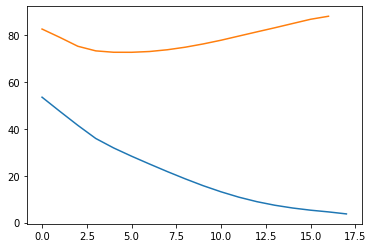

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([np.mean(losses[start:start+len(losses)])  for start in range(0, len(losses), len(train_loader))])
plt.plot([np.mean(test_loss[start:start+len(test_loss)]) for start in range(0, len(test_loss), len(test_loader))])

In [36]:
import itertools
with torch.no_grad():
  for inp, inp_len, op, op_len in test_loader:
      
      inp, inp_len = inp.float().to(device), inp_len.long().to(device)
      op, op_len = op.long().to(device), op_len.long().to(device)

       

      p = net(inp)
      start = 0
      for pi, o in zip(p, op_len):
        
        
        print (''.join(index2char[i] for i in op[start:start+o].cpu().numpy()))
        for i in (k for k, g in itertools.groupby(pi.argmax(1).cpu().numpy())):
          
          if i < len(index2char):
            print (index2char[i], end = '')
        print ('\n')
        start += o

<maybe today'll be a good news day>
<hemaybe troode a be a dit elmes a>  

<the oasis was a mirage>
<he awiysefsas an oros 

<often dominant stress simply indicates a centering of attention or emotion>
<ofen' gog a ts tressiply an eases seoring ov atanion ori anocian> 

<swing your arm as high as you can>
<swenmneur rmays hiz ecan 

<eating spinach nightly increases strength miraculously>
<itnin sannich lihtlyn hresesstoon more culasty>  

<this group is secularist and their program tends to be technological>
<his crewp is seycuom er ist inther peurbrafed tensity pcnological> 

<don't ask me to carry an oily rag like that>
<n't ask me to carry an oily rag like that>

<john cleans shellfish for a living>
<gohn pleaans shellfisch forlad in> 

<his shoulder felt as if it were broken>
<his shorder folldars af tiat wor broke an> 

<ralph controlled the stopwatch from the bleachers>
<werallh contrel this popwots fon the bi tost> 

<she had your dark suit in greasy wash water all year>
<he ha